# Michele M. Crudele - 2021858

# Data Management Assignment

# Fun Exercise

In [1]:
print("1^2 =", 1^2)
print("2^5 =", 2^5)
print("3^7 =", 3^7)
print("5^9 =", 5^9)
print("The operation to be computed is the XOR: 4^5 =", 4^5)

1^2 = 3
2^5 = 7
3^7 = 4
5^9 = 12
The operation to be computed is the XOR: 4^5 = 1


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 1. Redundancy

## 1.1 Write a program (C,C++, R or Python), which produces four striped data and one parity file as described above using the given input file.

In [3]:
N = 4 # Number of bytes to be read from the input file at each iteration of the loop

# Create output files
f0 = open("raid4.0", "wb")
f1 = open("raid4.1", "wb")
f2 = open("raid4.2", "wb")
f3 = open("raid4.3", "wb")
f4 = open("raid4.4", "wb")

# Read input file
with open("raid4.input.pdf", "rb") as f:
    # Read N bytes
    bytes = f.read(N)
    
    while bytes != b"":
        b  = [0] * N
        bb = 0
        
        for i in range(N):
            if i<len(bytes):
                b[i] = bytes[i:(i+1)]
            else:
                b[i] = (0).to_bytes(1,'big')
         
        # Compute parity
        for i in range(N):
            bb ^= b[i][0]
        
        f0.write(b[0])
        f1.write(b[1])
        f2.write(b[2])
        f3.write(b[3])
        f4.write(bb.to_bytes(1,'big'))
        bytes = f.read(N)

f0.close()
f1.close()
f2.close()
f3.close()
f4.close()

In [4]:
# check on a little part of the created file
with open("raid4.4", "rb") as f:
    byte = f.read(1)
    i = 0
    while byte != b"":
        if i<7:
            print(byte, byte[0])
            i += 1
        byte = f.read(1)

b'w' 119
b'\x01' 1
b'\x0e' 14
b'[' 91
b'G' 71
b'\xd8' 216
b'\x1d' 29


## 1.2 - Column-wise parity 
The column-wise parity acts as a CHECK-SUM for each stripe file.
To calculate it, we define a function which computes the column-wise parity given the file name in input.

In [5]:
def column_parity(filename):
    
    with open(filename, "rb") as f:
        
        byte = f.read(1)
        
        bb = 0
        
        while byte != b"":
            
            bb ^= byte[0]
            
            byte = f.read(1)
    
    return hex(bb)

In [6]:
a0 = column_parity("raid4.0")
a1 = column_parity("raid4.1")
a2 = column_parity("raid4.2")
a3 = column_parity("raid4.3")
a4 = column_parity("raid4.4")

In [7]:
print(a0, a1, a2, a3, a4)

0xa5 0x7 0xa0 0x9c 0x9e


The size overhead is evaluated by comparing the sizes of all the five stripe files with the original file size. 
Each of the five stripe files is 43 KB, while the input file is 171 KB (I read the file size directly on my computer, by right-clicking on the files): the size overhead is about 26% = (43*5 - 171) / 171.

## 1.3 - 5-byte parity value in hex format

In [8]:
par = (int(a0,16)<<32) | (int(a1,16)<<24)| (int(a2,16)<<16) | (int(a3,16)<<8) | int(a4,16)

print("The 5-byte parity is:", hex(par)) 

The 5-byte parity is: 0xa507a09c9e


We can check that the 5-byte parity is computed correctly by comparing it with a0, a1, a2, a3 and a4

## 1.4 - Row-wise parities of the five stripe files

If we create a sixth stripe file, which contains the row-wise parities of the five stripe files, the content of this file will be all zeros since the operation applied would be $P~ \hat{~} P$.
Let us verify it.

In [9]:
N = 4

# Output files
f0 = open("raid4.0", "wb")
f1 = open("raid4.1", "wb")
f2 = open("raid4.2", "wb")
f3 = open("raid4.3", "wb")
f4 = open("raid4.4", "wb")
f5 = open("raid4.5", "wb")

# Read input file
with open("raid4.input.pdf", "rb") as f:
    
    # Read N bytes
    bytes = f.read(N)
    
    while bytes != b"":
        b   = [0] * N
        bb  = 0
        bbb = 0
        
        for i in range(N):
            if i < len(bytes):
                b[i] = bytes[i:(i+1)]
            else:
                b[i] = (0).to_bytes(1, 'big')
            
        for i in range(N):
            bb  ^= b[i][0]
            bbb ^= b[i][0]
        
        bbb ^= bb
         
        f0.write(b[0])
        f1.write(b[1])
        f2.write(b[2])
        f3.write(b[3])
        f4.write(bb.to_bytes(1, 'big'))
        f5.write(bbb.to_bytes(1, 'big'))
        bytes = f.read(N)

f0.close()
f1.close()
f2.close()
f3.close()
f4.close()
f5.close()

Check they are all 0:

In [10]:
# check on some bytes
with open("raid4.5", "rb") as f:
    byte = f.read(1)
    i = 0
    while byte != b"":
        if i<7:
            print(byte, byte[0])
            i += 1
        byte = f.read(1)

b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0


## 1.5 - Reconstruct the original file raid4.input using the 5 stripe files.

After some time, we recompute the 5-byte parity value and now the result is $P^5 = \text{0x a5 07 a0 01 9e}$. Something has been corrupted. 
We want to reconstruct the original file “raid4.input” using the 5 stripe files.
We proceed as follows: for instance, if the first stripe “raid4.0” is corrupted, we can reconstruct it as follows:

$$
P \hat{} x_2 \hat{} x_3 \hat{} x_4
=
x_1 \hat{} x_2 \hat{} x_3 \hat{} x_4 \hat{} x_2 \hat{} x_3 \hat{} x_4
=
x_1 \hat{} 0 \hat{} 0 \hat{} 0
=
x_1
$$

where $P$ is the parity stripe (raid4.4) and $x_2,x_3,x_4$ are respectively “raid4.1”, “raid4.2”, “raid4.3”; $x_1$ is "raid4.0", the one that we want to retrieve.

In [11]:
# Open stripe files
f0 = open("raid4.0", "rb")
f1 = open("raid4.1", "rb")
f2 = open("raid4.2", "rb")
f3 = open("raid4.3", "rb")
f4 = open("raid4.4", "rb")

# Read the first byte for each stripe
b0 = f0.read(1)
b1 = f1.read(1)
b2 = f2.read(1)
b3 = f3.read(1)
b4 = f4.read(1)

i = 0
while b0 != b"" and i<20:
    # Compute the parity between the stripe files
    P = b4[0] ^ b1[0] ^ b2[0] ^ b3[0]
    print(b0, "\t", P.to_bytes(1, 'big'))
    i += 1
    b0 = f0.read(1)
    b1 = f1.read(1)
    b2 = f2.read(1)
    b3 = f3.read(1)
    b4 = f4.read(1)

f0.close()
f1.close()
f2.close()
f3.close()
f4.close()

b'%' 	 b'%'
b'-' 	 b'-'
b'\n' 	 b'\n'
b'\xf2' 	 b'\xf2'
b'\xf3' 	 b'\xf3'
b'\xc6' 	 b'\xc6'
b'0' 	 b'0'
b'j' 	 b'j'
b' ' 	 b' '
b'n' 	 b'n'
b' ' 	 b' '
b' ' 	 b' '
b'F' 	 b'F'
b'e' 	 b'e'
b'F' 	 b'F'
b'e' 	 b'e'
b'o' 	 b'o'
b'>' 	 b'>'
b't' 	 b't'
b'm' 	 b'm'


As we can see the reconstructed file is the same as the original one.

# 2. Cryptography

## 2.1 -  Symmetric or Asymmetric encription?
This is a symmetric encription since we can encode and decode the message using the same key.

## 2.2 - Retrieve original message

In [12]:
encoded = "K]amua!trgpy"

nonce  = np.arange(5, len(encoded)+5, dtype=int)
asciii    = np.array([ord(l) for l in encoded])

print('Original text: ', encoded)
print('Encoded ASCII text: ', asciii)

# Brute force: we just go through the encription algorithm in reverse way
# The modulo operation stays the same and restricts the possible range to [0, 256]

for key in range(0, 256):
    
    # Subtract key and nonce
    decoded = asciii - nonce - key
    
    # Restrict range to [0, 256]
    decoded[np.where(decoded < 0)] = decoded[np.where(decoded<0)] % 256 
    
    reverted = ''.join(chr(c) for c in decoded)
    
    print("\nKey: ", key, " Decription: ", reverted)

Original text:  K]amua!trgpy
Encoded ASCII text:  [ 75  93  97 109 117  97  33 116 114 103 112 121]

Key:  0  Decription:  FWZelWheYai

Key:  1  Decription:  EVYdkVgdX`h

Key:  2  Decription:  DUXcjUfcW_g

Key:  3  Decription:  CTWbiTebV^f

Key:  4  Decription:  BSVahSdaU]e

Key:  5  Decription:  ARU`gRc`T\d

Key:  6  Decription:  @QT_fQb_S[c

Key:  7  Decription:  ?PS^ePa^RZb

Key:  8  Decription:  >OR]dO`]QYa

_\PX`

Key:  10  Decription:  <MP[bM^[OW_

Key:  11  Decription:  ;LOZaL]ZNV^

Key:  12  Decription:  :KNY`K
\YMU]

Key:  13  Decription:  9JMX_J	[XLT\

Key:  14  Decription:  8ILW^IZWKS[

Key:  15  Decription:  7HKV]HYVJRZ

Key:  16  Decription:  6GJU\GXUIQY

Key:  17  Decription:  5FIT[FWTHPX

Key:  18  Decription:  4EHSZEVSGOW

Key:  19  Decription:  3DGRYDURFNV

Key:  20  Decription:  2CFQXCTQEMU

Key:  21  Decription:  1BEPWBSPDLT

Key:  22  Decription:  0ADOVA ROCKS

Key:  23  Decription:  /@CNU@ÿQNBJR

Key:  24  Decription:  .?BMT?þPMAIQ

Key:  25  Dec

As we can see from the output, we find that the key is 246 and the original message text is "Padova rocks".

# Object Storage

## 3.1 & 3.2 - Simulate the placement of fixed size files to random locations 

We fill 10 hard disks of 1TB space each with fixed size files until one of the hard disks is full.
To simulate this process, we write a function that takes in input the fixed file size and return various useful outputs: 
1. The number of files we manage to place
2. The percentage of total used space

In [13]:
def hardisk(filesize = 10, plots = True, mean_std = False, std_out=False, out=False):
    
    # Set a random seed
    random.seed(280503)
    
    # Create a variable to store hard disk space
    disks = np.array([0.]*10)
    
    # Create a loop which stops 
    # once the first hard disk is full
    iter = True
    while(iter == True):
        disk = random.randint(0, 9)
        disks[disk] += filesize
        if(disks[disk] > 1000):
            disks[disk] -= filesize
            iter = False
        
    placed = int(np.sum(disks)/filesize)
    used = (np.sum(disks))/100
    
    if plots == True:
        fig, ax =  plt.subplots(figsize=(10,8))
        ax.bar(np.linspace(0,9, 10),disks,color="mediumseagreen")
        plt.xticks(range(0,10),range(0,10))
        ax.grid(True, color='lightgrey')
        ax.set_axisbelow(True)
        ax.set_xlabel('Hard disk #', fontsize=16)
        ax.set_ylabel('Used space [GB]', fontsize=16)
        ax.hlines(1000,linestyle='dashed', xmin=-1, xmax=10, color="red")
        ax.set_xlim(-1,10)
        plt.show()
        
        print("Number of placed files:", placed)
        print("Used space on all hard disks:", format(used, ".2f"), "%")

    if out == True:
        return placed, used

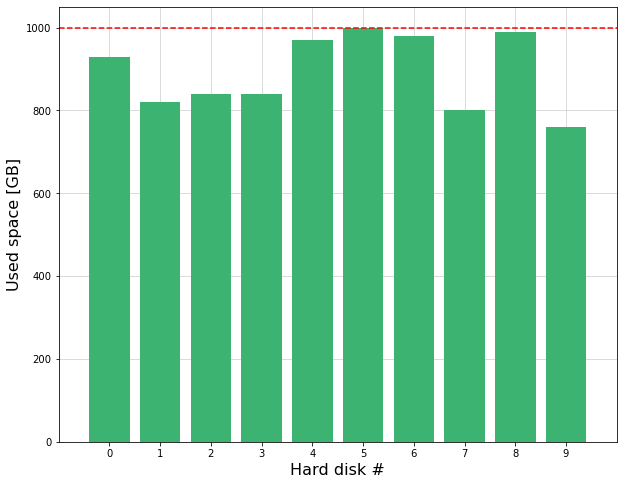

Number of placed files: 893
Used space on all hard disks: 89.30 %


In [14]:
hardisk(10) # case with 10GB files

Using 10 GB files, we are able to place 893 files with a percentage of used space on the hard disks of 89.30%.

In [15]:
#################################################################

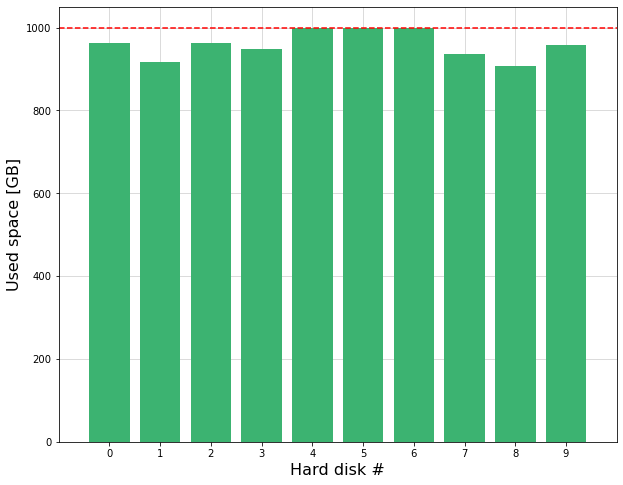

Number of placed files: 9590
Used space on all hard disks: 95.90 %


In [16]:
hardisk(1) # case with 1 GB files

Using 1 GB files, we are able to place 9590 files with a percentage of used space on the hard disks of 95.90%.

## 3.3 - Free space left as a function of file size

From the previous barplots we can observe that the smaller the file size the bigger the space we manage to use in the hard disks. 
This is sensible: if for example we use files of 600GB, it is very likely that one of them goes beyond the space treshold and stops the loop before each of the disks is filled with one file; in this case, in the worst of the cases we would end up with only one hard disk filled with a 600GB file and all the others empty.
By using smaller files, we are able to go through more iterations of the loop, filling the disks with more files and using more space, since we fill the hard disks gradually.

On the other hand, the smaller the file size the larger the number of files we have to place in the hard disks and the time required to store them.

Then, 4 MB can be a sensible trade-off between used space and number of files to be stored.

To summarize, small block sizes reduces the amount of storage wasted, but increases the number of blocks that must be read for a constant amount of data; large block sizes reduces the number of blocks that must be read for a constant amount of data, but increases the amount of storage wasted.

The following plots confirm this behaviour.

Using 4 MB files, we are able to place 2495240 files with a percentage of used space on the hard disks of 99.81%.
We show the obtained distribution with the following barplot.

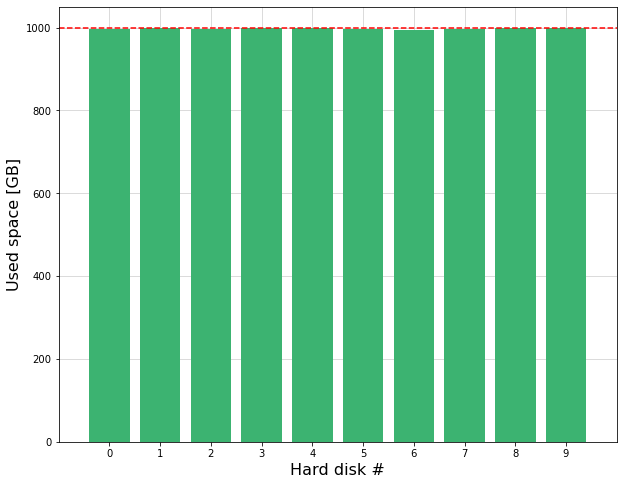

Number of placed files: 2495240
Used space on all hard disks: 99.81 %


In [17]:
hardisk(0.004)

As we can see from the plot above, the unused space in the hard disks is very small for 4MB files

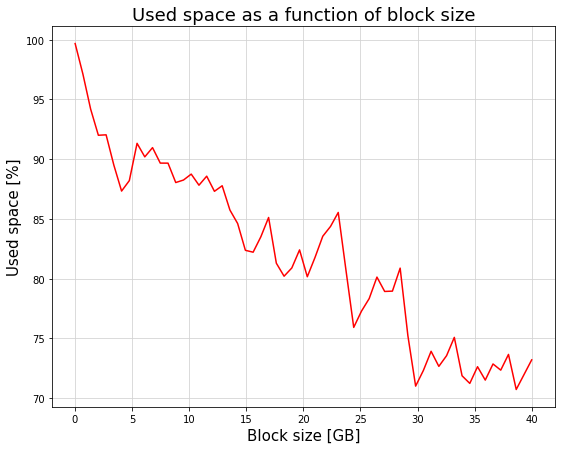

In [18]:
low = 0.01
high = 40
sizes = np.linspace(low, high, 60)
y=[]

for size in sizes:
    p, u = hardisk(size, plots=False, out=True)
    y.append(u)
    
# Plot the results
fig, ax =  plt.subplots(figsize=(9,7))
ax.plot(sizes, y, color="red", label='Free Space Left')
ax.grid(True, color='lightgrey')
ax.set_xlabel('Block size [GB]',fontsize=15)
ax.set_ylabel('Used space [%]',fontsize=15)
ax.set_title("Used space as a function of block size",fontsize=18)
plt.show()

## 3.4. - Compute the average used space on all hard disks and the standard deviation for the average used space for 10 GB and 1GB and 4M files. How is the standard deviation correlated to the block size and why?

In [19]:
def mean_std(filesize = 10, num_disks = 10, plots = True, 
             mean_std = True, std_out=False, out=True):

    random.seed(280503)
    N = num_disks
    
    # N hard disks
    disks = np.array([0.] * N)
    
    # Stop the loop when
    # one hard disk is full
    iter = True
    while(iter == True):
        disk = random.randint(0, N-1)
        disks[disk] += filesize
        if(max(disks) > 1000):
            disks[disk] -= filesize
            iter = False

    if mean_std==True:
        print("File Size: ", filesize, "GB")
        print("The average used space per disk is:", format(np.mean(disks), ".2f"), "GB")
        print("The standard deviation for the average used space per disk is:", 
              format(np.std(disks), ".2f"), "GB")
    
    if std_out==True:
        return(np.std(disks))
    
    if out == True:
        return (disks)

In [20]:
mean_std(filesize = 10, num_disks = 10, plots = False, mean_std = True, out=False)

File Size:  10 GB
The average used space per disk is: 893.00 GB
The standard deviation for the average used space per disk is: 85.45 GB


In [21]:
mean_std(filesize = 1, num_disks = 10, plots = False, mean_std = True, out=False)

File Size:  1 GB
The average used space per disk is: 959.00 GB
The standard deviation for the average used space per disk is: 31.39 GB


In [22]:
mean_std(filesize = 0.004, num_disks = 10, plots = False, mean_std = True, out=False)

File Size:  0.004 GB
The average used space per disk is: 998.10 GB
The standard deviation for the average used space per disk is: 1.38 GB


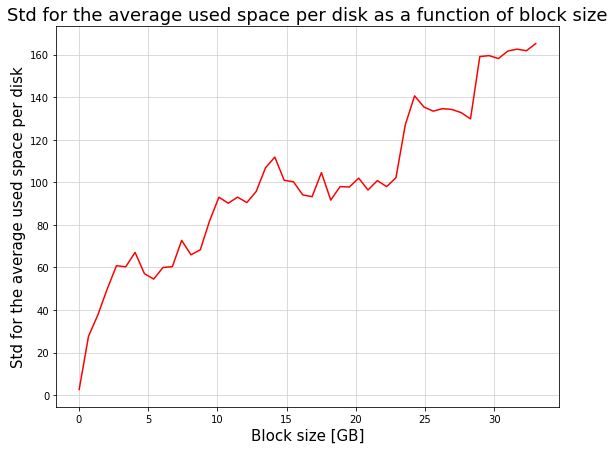

In [23]:
min_size = 0.01
max_size = 33
sizes = np.linspace(min_size, max_size, 50)
std=[]

for size in sizes:
    stand = mean_std(size, plots = False, mean_std=False, std_out=True)
    std.append(stand)
    
# Plot the results
fig, ax =  plt.subplots(figsize=(9,7))
ax.plot(sizes, std, color="red", label='Free Space Left')
ax.grid(True, color='lightgrey')
ax.set_xlabel('Block size [GB]',fontsize=15)
ax.set_ylabel('Std for the average used space per disk',fontsize=15)
ax.set_title("Std for the average used space per disk as a function of block size",
             fontsize=18)
plt.show()

## If we now repeat such an experiment for many more hard disks, which kind of distribution do you get when you do a histogram of the used space of all hard disks?

In [24]:
a = mean_std(filesize = 10, num_disks = 800, plots = False)
b = mean_std(filesize = 1, num_disks = 800, plots = False)
# i do not run with 4MB files, since it is too slow

File Size:  10 GB
The average used space per disk is: 745.06 GB
The standard deviation for the average used space per disk is: 84.82 GB
File Size:  1 GB
The average used space per disk is: 912.41 GB
The standard deviation for the average used space per disk is: 28.19 GB


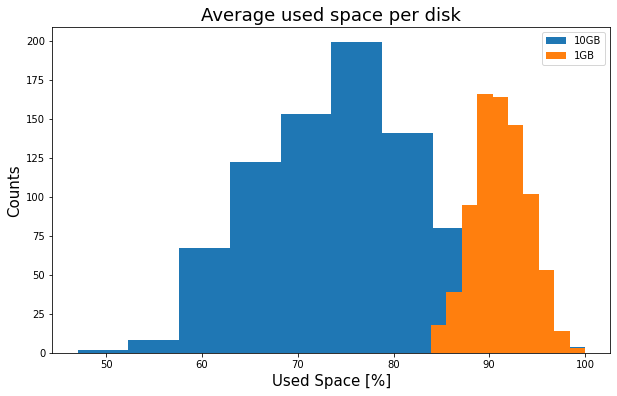

In [25]:
fig, ax =  plt.subplots(figsize=(10,6))
ax.hist(a/10, label='10GB')
ax.hist(b/10, label='1GB')
ax.set_xlabel("Used Space [%]",fontsize=15)
ax.set_ylabel('Counts',fontsize=15)
ax.set_title("Average used space per disk",
             fontsize=18)
ax.legend()

plt.show()

As we can see from the histograms above, the smaller the size of the files, the larger the average used space per disk and the smaller the standard deviation related to it. This is a sensible result, since from the previous barplots we can notice that the used space per disk becomes more similar when using smaller file sizes: this means that the dispersion around the mean value decreases.
The reason for this trend is explained in the point 3.3.
As far as the kind of distribution, we can see that it is almost gaussian: this is due to central limit theorem, since each disk is filled randomly.

# 4. Rest APIs & Block Chain Technology

In order to solve this exercise, we decide to use the "requests" library.

In [26]:
import time
import requests

In [27]:
# api-endpoint
URL = "https://pansophy.app:8443"
  
# sending GET request and saving the response as response object
r = requests.get(url = URL, verify=False)
  
# extracting data in json format
data = r.json()
# uncomment the following line to show the output of the GET request
# data

/Users/michelecrudele/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [28]:
# defining the api-endpoint 
API_ENDPOINT = "https://pansophy.app:8443"

# data to be sent to api
data = {"operation": "merit",
        "team": "AC Milan",
        "coin": 100,
        "stealfrom": "genesis"}

# sending POST request to initiate a transaction (merit)
r = requests.post(url = API_ENDPOINT, json = data, verify=False)

# extracting response text 
print("Request", r.text)


time.sleep(10.0) # Sleep time to respect the Proof of Time


# defining the api-endpoint 
API_ENDPOINT = "https://pansophy.app:8443"

# data to be sent to api
data = {"operation": "claim",
        "team": "AC Milan",
       }

# sending POST request to conclude a transaction (claim)
r = requests.post(url = API_ENDPOINT, json = data, verify=False)

# extracting response text 
print("Transaction:", r.text)

# check trasaction with GET request
r = requests.get(url = URL, verify=False)  
# extracting data in json format
data = r.json()
data

/Users/michelecrudele/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Request {"msg": "accepted"}


/Users/michelecrudele/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Transaction: {"msg": "request claimed"}


/Users/michelecrudele/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pansophy.app'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


{'accounts': {'AC Milan': 500,
  'Andreas J. Peters': 1000,
  'BellaZio': 282225,
  'FaoTom': 1000,
  'Fogliame': 600,
  'Giovanni': 100,
  'Oesais': 200,
  'PaoloMuschio': 600,
  'Team1': 100,
  'bellaZio': 1000,
  'genesis': 712675},
 'chain': [{'coins': 1000000,
   'debit': 'genesis',
   'index': 0,
   'my_hash': '58f3f485104a26b61060837a2087bbb5a14ba709e380dbaed452ed9e9cb39427',
   'prev_hash': '0',
   'team': 'genesis',
   'timestamp': 1622479658.282847},
  {'coins': 1000,
   'debit': 'genesis',
   'index': 1,
   'my_hash': 'baa43458ac89290b22c8e2e3fa0689265d47e45acb8e2980227f74eab01e23ac',
   'prev_hash': '58f3f485104a26b61060837a2087bbb5a14ba709e380dbaed452ed9e9cb39427',
   'team': 'Andreas J. Peters',
   'timestamp': 1622533027.813872},
  {'coins': 25,
   'debit': 'genesis',
   'index': 2,
   'my_hash': '02f5ec3fd3e2fa557efbe2f3c809d56c7786098d13c4f1872ee90c1530c396db',
   'prev_hash': 'baa43458ac89290b22c8e2e3fa0689265d47e45acb8e2980227f74eab01e23ac',
   'team': 'BellaZio',
  

We can check that our transaction has been added at the end of the chain and our account is present.

## 4.1.2 - What is the maximum number of transactions one given team can add to the Block Chain in one day?

After having checked that we are able to add more 240 transactions to the block chain in a day, we can assume that the only limitation on the number of transactions is given by the Proof of Time.
As a consequence, the maximum number of transaction one team can add to the chain in one day is equal to the seconds in a day divided by 10, that are the seconds we need to wait before claiming each transaction:

60 * 60 * 24 / 10 = 8640

We need to be aware that the account we steal coins from has enough coins left and that we cannot steal the last coin from an account that has only one coin; otherwise, our transaction will be discarded. Moreover, bottlenecks in the blockchain can lower this estimate.

## 4.2 & 4.2.1 - The server has a function to compute a hash of a block in the Block Chain. Explain what this function does and why is this ‘the key’ for Block Chain technology?

The "calculate_hash" function generates the hash of the string given in input using some of the parameters related to a block (index, team, previous hash, coins and timestamp). It hashes this string using the SHA-256 hash algorithm.

After the values have been fed into the cryptographic hash algorithm, the function will return a 256-bit string representing the contents of the block. 
In this way, every block will have a hash and that hash is based on the hash of the previous block. 

This means that if someone tries to compromise any block in the chain, the other blocks will have invalid hashes, leading to disruption of the entire blockchain network.

This is why this function is the core of the security of the block chains.

## 4.2.2 - If you have the knowledge of the hash function, how can you validate the contents of the Block Chain you received using a GET request to make sure, nobody has tampered with it? You don’t need to implement it! Explain the algorithm to validate a Block Chain!

In order to verify the chain, we can just go through all the blocks and check the consistency of the current one with its predecessor. 
In order to do that, we can simply use "if" statements to check whether the hash (but also the index and the timestamp) of every block is correct. 

If everything is correct, it returns true; otherwise, it returns false. The algorithm can be something like the following:

In [29]:
def check_validity(block, prev_block):
  
  if prev_block.index + 1 != block.index:
    return False

  elif prev_block.calculate_hash != block.prev_hash:
    return False

  elif block.timestamp <= prev_block.timestamp:
    return False

  return True

## 4.2.3 - Why might the GET REST API run into scalability problems? Express the scalability behaviour of execution times of GET and POST requests in Big O notation in relation to the number of transactions recorded in the Block Chain! Draw execution time vs transactions for GET and POST requests.

The GET REST API might run into scalability problems when the number of blocks in the chain becomes huge, since every time it is called, it has to read all the blocks in the chain: for this reason, the execution time of GET grows as O(N), where N is the number of transactions recorded in the Bock Chain.
The POST request instead, does not have to read all the chain, so its execution time is constant: O(1).

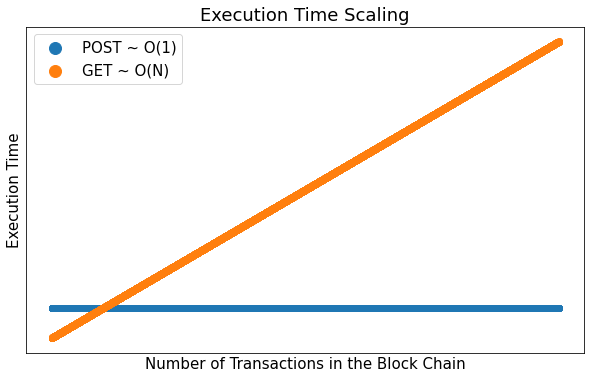

In [30]:
x = np.linspace(0, 1, 10000)

fig, ax =  plt.subplots(figsize=(10,6))
ax.scatter(x, [0.1]*len(x), label="POST ~ O(1)")
ax.scatter(x, x, label="GET ~ O(N)")
ax.set_xlabel("Number of Transactions in the Block Chain",fontsize=15)
ax.set_ylabel('Execution Time',fontsize=15)
ax.set_title("Execution Time Scaling",
             fontsize=18)
ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
ax.legend(fontsize=15, markerscale=2)

plt.show()

## 4.2.4 - If the Crypto server goes down, the way it is implemented it loses the current account balances. How can the server recompute the account balances after a restart from the saved Block Chain?

We can just go through all the transactions in the chain and add "coins" to the "team" and subtract "coins" from the "debit".

## 4.2.5 - What are the advantages of using a REST API and JSON in a client-server architecture? What are possible disadvantages?

Advantages of REST API:

1.  Separation between the client and the server: the REST protocol totally separates the user interface from the server and the data storage. This has some advantages when making developments. For example, it improves the portability of the interface to other types of platforms, it increases the scalability of the projects, and allows the different components of the developments to be evolved independently.
2. Visibility, reliability and scalability. The separation between client and server has one evident advantage, and that is that each development team can scale the product without too much problem. They can migrate to other servers or make all kinds of changes in the database, provided the data from each request is sent correctly. The separation makes it easier to have the front and the back on different servers, and this makes the apps more flexible to work with.
3. The REST API is always independent of the type of platform or languages: the REST API always adapts to the type of syntax or platforms being used, which gives considerable freedom when changing or testing new environments within the development. With a REST API you can have PHP, Java, Python or Node.js servers. The only thing is that it is indispensable that the responses to the requests should always take place in the language used for the information exchange, normally XML or JSON. 
4. With the initial URI, the client does not require routing information.
5. Easy to use


Disadvantages of REST API:

1. The lack of state is the most problematic aspect of REST. It means that the one who needs to maintain the state is the client, making the client application complicated to keep up;
2. Lack of security: REST does not impose security. That is the reason REST is appropriate for public URLs, but it is not good for confidential data passage between client and server. 